In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import os
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Loading Dataset

In [10]:
if os.path.isfile('final.sqlite'):
    conn = sqlite3.connect('final.sqlite')
    final = pd.read_sql_query('select * from reviews limit 2000', conn)
    conn.close()
else:
    print('Please run Text Preprocessing code file')

In [11]:
# global variables
score = final['Score']
tsne_model = TSNE(n_components=2, random_state=0, perplexity=35, n_iter=5000)

# BOW t-sne representation

In [12]:
count_vect = CountVectorizer()
bow_sparse_matrix = count_vect.fit_transform(final['CleanedText'].values)
standardized_data = StandardScaler(with_mean=False).fit_transform(bow_sparse_matrix) # column standardizing sparse matrix
tsne_data = tsne_model.fit_transform(standardized_data.toarray())
tsne_data

array([[-16.439651  ,  -2.0023468 ],
       [-78.5174    , 192.71655   ],
       [ -8.296562  ,   0.34307697],
       ...,
       [ 10.184989  ,  -5.932878  ],
       [ -8.245834  ,   3.4641194 ],
       [  3.6314452 , -13.322049  ]], dtype=float32)

In [16]:
print(type(tsne_data))
tsne_data.shape

<class 'numpy.ndarray'>


(2000, 2)

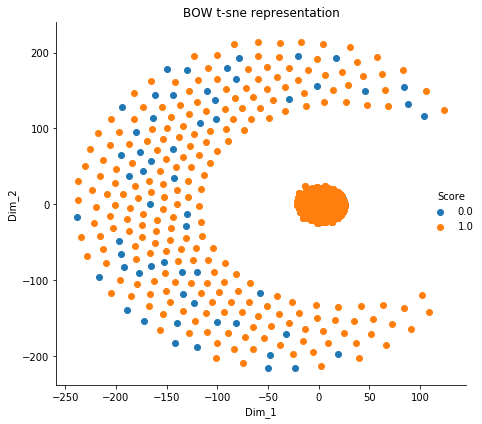

In [23]:
tsne_data = np.vstack((tsne_data.T, score)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=('Dim_1', 'Dim_2', 'Score'))
sns.FacetGrid(tsne_df, hue='Score', size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('BOW t-sne representation')
plt.tight_layout()